In [14]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import cdsapi
from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [3]:
climatology = xr.open_dataset('/nobackup/users/lulur/Daily_hist_temps/air.2m.day.1981-2010.ltm.nc')
climatology.coords['dayofyear'] = climatology.time.dt.dayofyear
climatology_doy = climatology.drop('time')

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime o

In [4]:
climatology

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:             (lat: 94, lon: 192, nbnds: 2, time: 365)
Coordinates:
  * lat                 (lat) float32 88.54 86.65 84.75 ... -84.75 -86.65 -88.54
  * lon                 (lon) float32 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:0...
    dayofyear           (time) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    air                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes:
    Conventions:                    COARDS
    title:                          mean daily NMC reanalysis (1981)
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/06/28 by doDayLTM\nConverted...
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [5]:
def load_temps(year):
    dataset = xr.open_dataset('/nobackup/users/lulur/Daily_hist_temps/air.2m.gauss.'+str(year)+'.nc')
    return dataset

In [88]:
def find_anomalies_draft(year):
    daily_temps = load_temps(year)
    daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
    daily_temps_doy = daily_temps.drop('time')
    daily_temps['anomalies'] = daily_temps_doy['air']-climatology_doy['air']
    return daily_temps

def find_anomalies(year):
    daily_temps = load_temps(year)
    daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
    daily_temps_copy = daily_temps.copy()
    time = daily_temps_copy.time
    daily_temps = daily_temps.drop('time')
    air = daily_temps.air
    if air.shape[0]>365:
        #daily_temps['air'] = air.where(air.dayofyear!=air.dayofyear[59], drop=True)
        air = air.where(air.dayofyear!=air.dayofyear[60], drop=True)
        #print(air.shape)
        time = time.where(time.dayofyear!=time.dayofyear[59], drop=True)
        #print(time.shape)
    daily_anomalies = xr.Dataset(
        data_vars=dict(
            air=(["time","lat", "lon"], air)
            ),
        coords=dict(
            lon=(["lon"], daily_temps.lon),
            lat=(["lat"], daily_temps.lat),
            time=time))
             #reference_time=reference_time,
     #attrs=dict(description="Weather related data."),
 

        #time[air.dayofyear>60]-= timedelta(days=1)
        #daily_temps.drop('dayofyear')
        #print(daily_temps)
        #daily_temps['air']=air
        #daily_temps['time'] = time
        
    daily_anomalies['anomalies'] = air-climatology_doy['air']
    daily_anomalies = daily_anomalies.drop('dayofyear')
    return daily_anomalies

In [89]:
year = 1980
# daily_temps = load_temps(year)
# daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
# daily_temps_doy = daily_temps.drop('time')
# air = daily_temps_doy.air
# print(daily_temps['air'].shape)
# air_dropped = air.where(air.dayofyear!=air.dayofyear[60], drop=True)
# air_dropped
#daily_temps['anomalies'] = daily_temps_doy['air']
#daily_temps
data1980 = find_anomalies(1984)
data1980
# daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
# print(len(daily_temps['dayofyear']))
# daily_temps_doy = daily_temps.drop('time')


<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
Data variables:
    air        (time, lat, lon) float32 246.5 246.4 246.3 ... 255.3 255.3 255.3
    anomalies  (time, lat, lon) float32 2.282 2.239 2.217 ... 1.622 1.663 1.688

In [ ]:
air

In [90]:
data1979 = find_anomalies(1979)
data1980 = find_anomalies(1980)
histdata = xr.concat((data1979,data1980),dim='time')
years = np.arange(1981,2020)
for year in years:
    data_yr = find_anomalies(year)
    histdata = xr.concat((histdata,data_yr),dim='time')    

In [93]:
delayed_obj = histdata.to_netcdf(path=f"/nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc", mode='w', compute=False, engine='netcdf4', format='NETCDF4')
print(f"writing data to /nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc")

with progress.ProgressBar():
    results = delayed_obj.compute()

writing data to /nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc
[########################################] | 100% Completed |  0.2s


In [130]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(75,55))
    ak_slice = lat_slice.sel(lon=slice(188,255))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

def ne_america_mean(ds):
    lat_slice = ds.sel(lat=slice(45,30))
    ak_slice = lat_slice.sel(lon=slice(268,288))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

def arctic_mean(ds):
    lat_slice = ds.sel(lat=slice(90,60))
    lat = lat_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(lat_slice.dims) - {'time'}
    return (lat_slice * weight).mean(other_dims)

In [129]:
histdata

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, time: 14965)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
Data variables:
    air        (time, lat, lon) float32 239.6 239.6 239.5 ... 251.8 251.8 251.8
    anomalies  (time, lat, lon) float32 -4.648 -4.591 -4.583 ... -1.862 -1.837

In [131]:
print('calculating global mean')
gmsts = global_mean(histdata)
print('calculating alaska mean')
akmsts = alaska_mean(histdata)
print('calculating arctic mean')
arcmsts = arctic_mean(histdata)
print('calculating northeast america mean')
ne_amsts = ne_america_mean(histdata)


calculating global mean
calculating alaska mean
calculating arctic mean
calculating northeast america mean


In [148]:
climatology['air']

<xarray.DataArray 'air' (time: 365, lat: 94, lon: 192)>
[6587520 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    long_name:     mean Long Term Mean Daily Air temperature at 2 m
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    level_desc:    2 m
    statistic:     Long Term Mean
    parent_stat:   Mean
    valid_range:   [150. 400.]
    actual_range:  [194.016   312.89865]
    dataset:       NCEP Reanalysis Derived Products

In [149]:
#climatology = climatology.drop('dayofyear')
print('calculating global mean')
g_clim = global_mean(climatology['air'])
print('calculating alaska mean')
ak_clim = alaska_mean(climatology['air'])
print('calculating arctic mean')
arc_clim = arctic_mean(climatology['air'])
print('calculating northeast america mean')
ne_am_clim = ne_america_mean(climatology['air'])

calculating global mean
calculating alaska mean
calculating arctic mean
calculating northeast america mean


In [133]:
arcmsts

<xarray.Dataset>
Dimensions:    (time: 14965)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    air        (time) float32 250.0 249.8 249.9 250.4 ... 251.2 251.0 250.6
    anomalies  (time) float32 -0.2749 -0.396 -0.1327 ... 0.6701 0.6601 0.2065

In [118]:
timeslice = np.asarray(histdata['time'])
type(timeslice)

numpy.ndarray

In [169]:
g_clim['time'].dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 365)>
array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365])
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00

In [170]:
regions= ('Global','Alaska','Arctic','NE_America')
msts = (gmsts, akmsts, arcmsts, ne_amsts)
clims = (g_clim,ak_clim,arc_clim,ne_am_clim)

def plot_climatology(data_arrs):
    for i in range(4):
        plt.figure(figsize=(10,8))
        #timeslice = data_arrs[i].sel(time=slice('1989-01-01', '1995-12-31'))
        #timeslice = np.asarray(histdata['time'])
        #time = [i[0].dayofyear for i in data_arrs[i]['time']]
        plt.plot(data_arrs[i]['time'].dt.dayofyear,data_arrs[i],label = regions[i]+' mean surfacetemperature')
        #plt.xlim(1990,2000)
        plt.title(regions[i]+'Mean Surface Air Temperature')
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel(regions[i]+'Daily Mean Temperature Anomaly')
        plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_'+regions[i]+'_mean_airtemp.png')

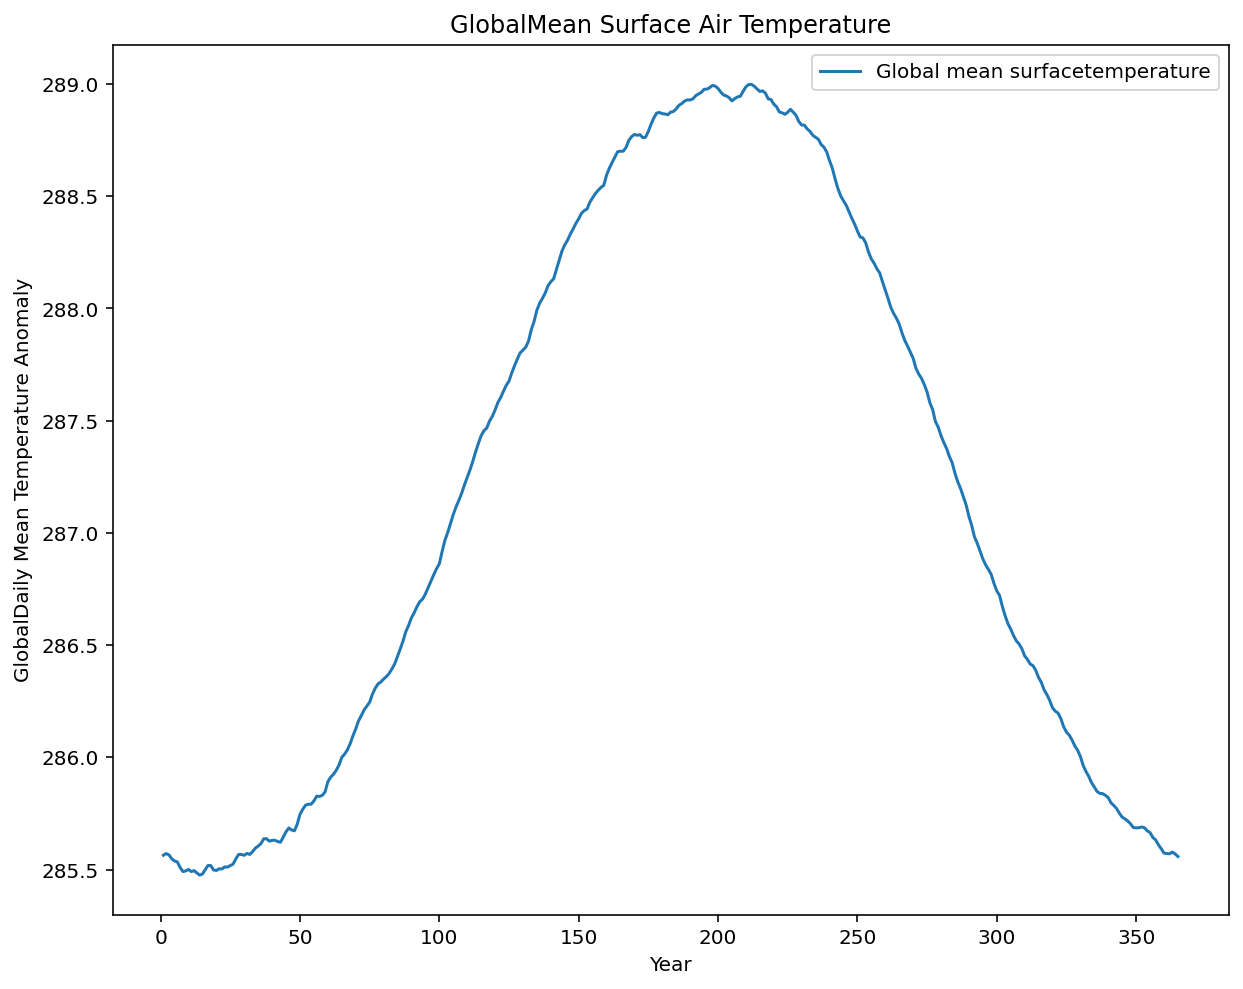

In [ ]:
plot_climatology(clims)

Text(0, 0.5, 'Arctic Daily Mean Temperature Anomaly')

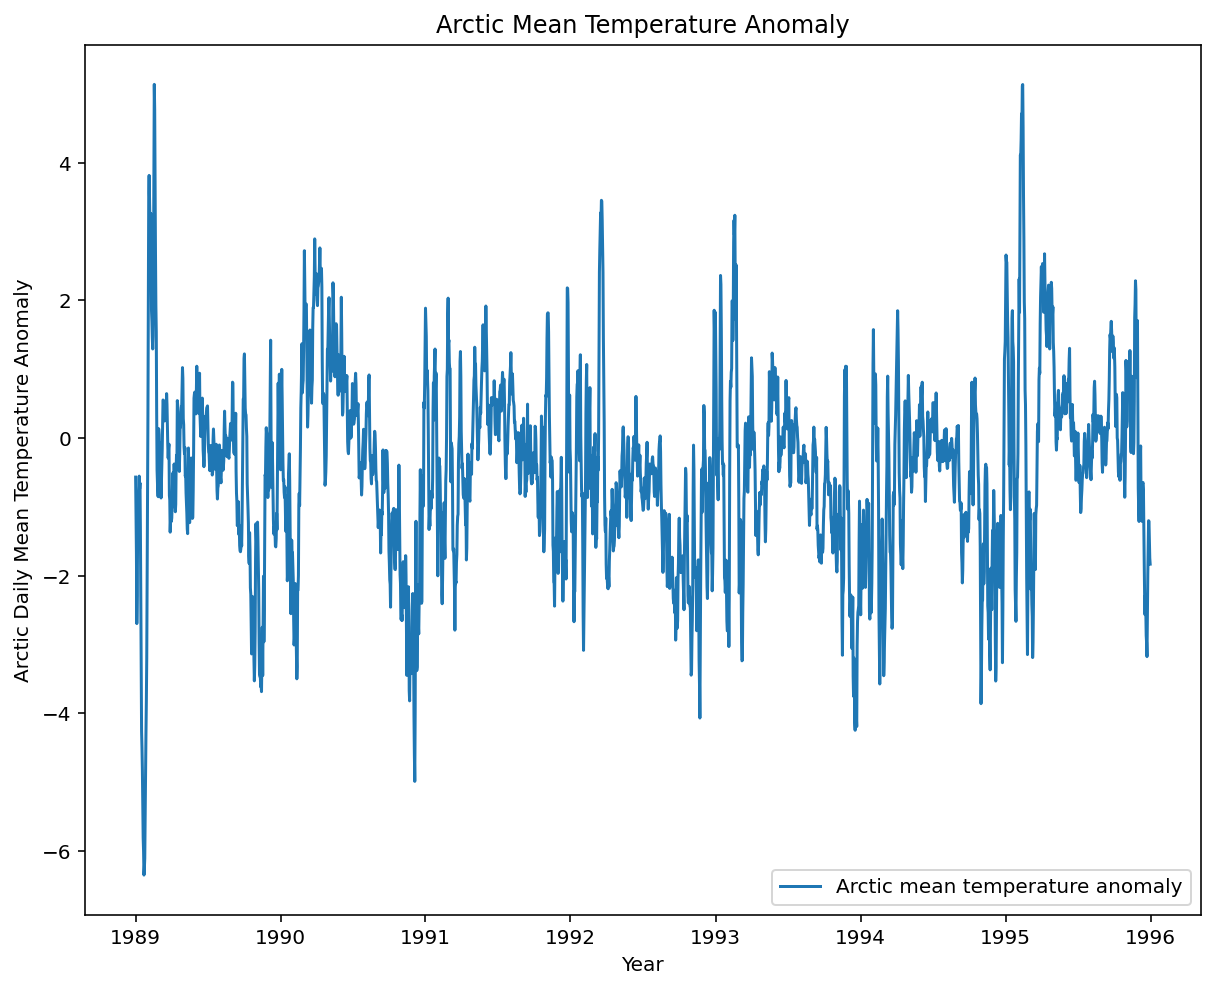

In [144]:
plt.figure(figsize=(10,8))
timeslice = arcmsts.sel(time=slice('1989-01-01', '1995-12-31'))
#timeslice = np.asarray(histdata['time'])
plt.plot(timeslice['time'],timeslice['anomalies'],label = 'Arctic mean temperature anomaly')
#plt.xlim(1990,2000)
plt.title('Arctic Mean Temperature Anomaly')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Arctic Daily Mean Temperature Anomaly')
#plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_arctic_mean_anomalies.png')

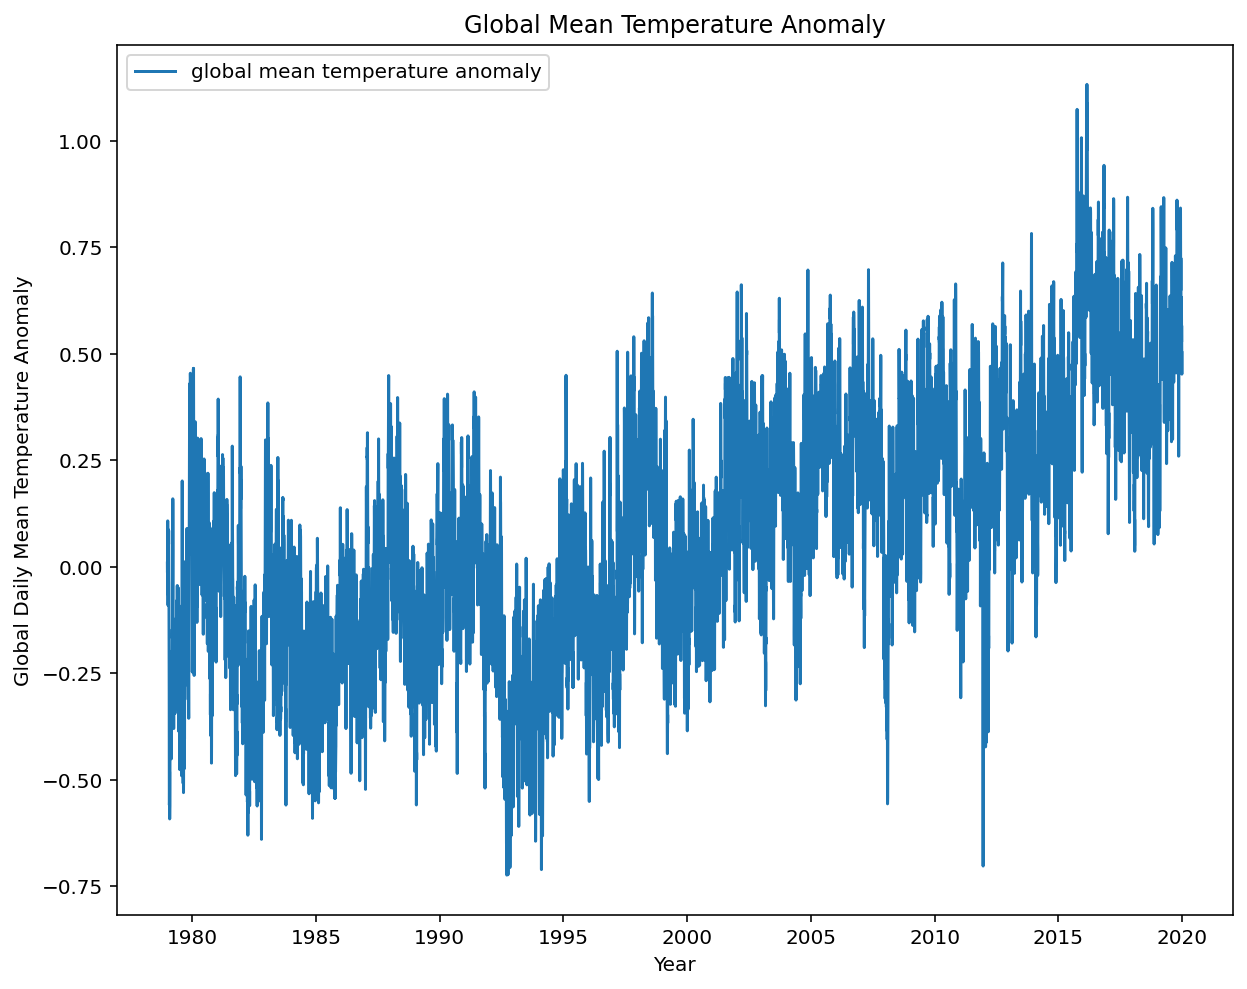

In [123]:
plt.figure(figsize=(10,8))
#timeslice = histdata.sel(time=slice('1979-01-01', '2020-12-31')).to_array
#timeslice = np.asarray(histdata['time'])
plt.plot(gmsts['time'],gmsts['anomalies'],label = 'global mean temperature anomaly')
#plt.xlim(1980,2100)
plt.title('Global Mean Temperature Anomaly')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Global Daily Mean Temperature Anomaly')
plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_global_mean_anomalies.png')